In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv("dataset/gas_turbine_fault_detection_simulated3.csv")  

df_fault = df[df["Fault"] == 1].copy()

cols_drop = ["Turbine ID", "TTC", "Fault", "Fault Mode"]  
X = df_fault.drop(columns=cols_drop)
y = df_fault["Fault Mode"]  # multiclase

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [3]:
f1_macro = make_scorer(f1_score, average="macro")

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

param_grid = [
    {
        "clf": [KNeighborsClassifier()],
        "clf__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
        
        "clf__weights": ['uniform', 'distance'],
        
        "clf__metric": ['minkowski', 'euclidean', 'manhattan'],
        "clf__p": [1, 2],
        
        "clf__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
        
        "clf__leaf_size": [20, 30, 40]
    }
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=f1_macro,        
    cv=5,                    
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor F1_macro CV:", grid.best_score_)


Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
Mejores hiperparámetros: {'clf': KNeighborsClassifier(), 'clf__algorithm': 'auto', 'clf__leaf_size': 20, 'clf__metric': 'minkowski', 'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'distance'}
Mejor F1_macro CV: 0.9468623598298421


In [4]:
best_clf = grid.best_estimator_

In [5]:
results_df = pd.DataFrame(grid.cv_results_)
results_df.columns = [col.replace('param_clf__', '').replace('param_', '') for col in results_df.columns]
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,clf,algorithm,leaf_size,metric,n_neighbors,p,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.036508,0.004031,0.833708,0.191803,KNeighborsClassifier(),auto,20,minkowski,3,1,...,0.942278,0.003452,469,0.971089,0.971346,0.972606,0.971041,0.970034,0.971223,0.000824
1,0.038454,0.002446,0.519755,0.098809,KNeighborsClassifier(),auto,20,minkowski,3,1,...,0.943224,0.003133,397,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.035422,0.005351,0.516195,0.113188,KNeighborsClassifier(),auto,20,minkowski,3,2,...,0.936045,0.004428,973,0.964977,0.965530,0.966485,0.965928,0.964370,0.965458,0.000734
3,0.035105,0.003724,0.343426,0.064435,KNeighborsClassifier(),auto,20,minkowski,3,2,...,0.936869,0.003910,937,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.030996,0.001645,0.609132,0.035909,KNeighborsClassifier(),auto,20,minkowski,5,1,...,0.945162,0.003125,289,0.963114,0.963058,0.964379,0.964319,0.963418,0.963658,0.000578


1. Diagnóstico: Sobreajuste (Overfitting)Existe una brecha significativa (gap) entre la línea azul (Train) y la línea naranja (Test).El modelo rinde casi perfecto en entrenamiento (~0.985 con $k=3$), pero cae considerablemente en test (~0.940).Esto indica que el modelo está memorizando patrones específicos del set de entrenamiento que no se generalizan totalmente al de prueba.2. El "Punto Dulce" (Sweet Spot)El mejor rendimiento en el set de prueba se alcanza en $k=7$.Antes de $k=7$: El error de test sube (especialmente en $k=3$), lo que sugiere que un número muy pequeño de vecinos hace que el modelo sea demasiado sensible al ruido.Después de $k=7$: El F1-score de test empieza a estancarse o declinar muy levemente.3. Análisis de Varianza y Sesgo (Bias-Variance Tradeoff)Varianza Alta: Se observa en los valores bajos de $k$. La zona sombreada azul (desviación estándar en train) es más ancha para $k=3$, lo que indica que el modelo es más inestable.Estabilización: A medida que $k$ aumenta, las sombras (varianza) se estrechan y las líneas se suavizan. El modelo se vuelve más robusto pero más simple (mayor sesgo).

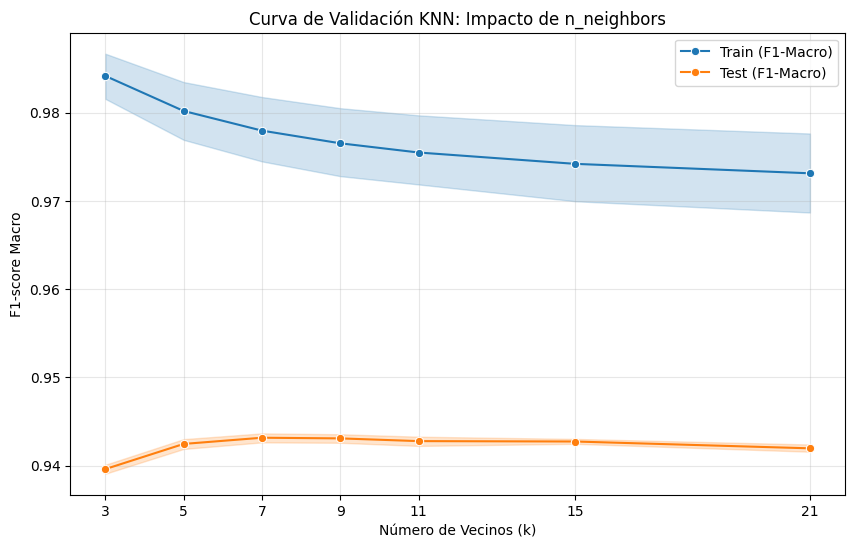

In [6]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=results_df, x='n_neighbors', y='mean_train_score', label='Train (F1-Macro)', marker='o')
sns.lineplot(data=results_df, x='n_neighbors', y='mean_test_score', label='Test (F1-Macro)', marker='o')

plt.title('Curva de Validación KNN: Impacto de n_neighbors')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('F1-score Macro')
plt.xticks(results_df['n_neighbors'].unique()) 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

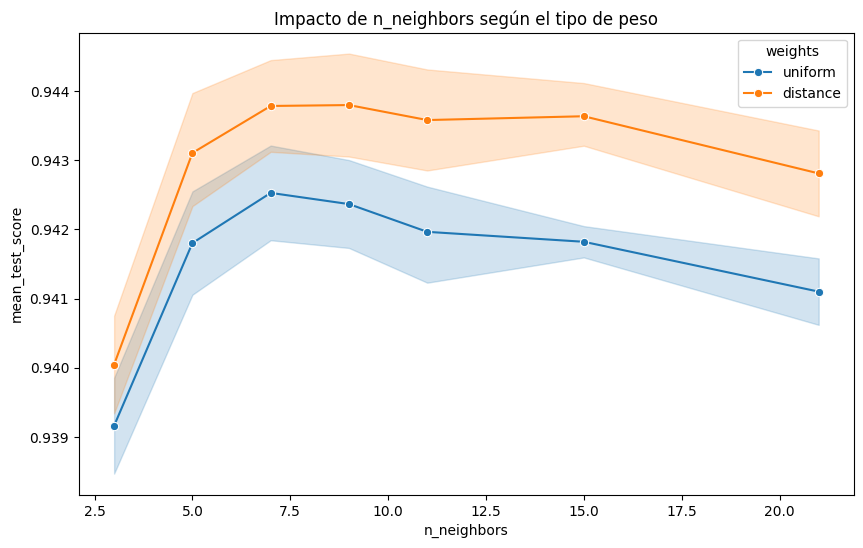

In [7]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='n_neighbors', y='mean_test_score', hue='weights', marker='o')
plt.title('Impacto de n_neighbors según el tipo de peso')
plt.show()

1. Empate Técnico en RendimientoLo primero que destaca es que los 5 modelos tienen un desempeño prácticamente idéntico.Consistencia de parámetros: Todos los modelos "Top" coinciden en usar $K=11$ y weights='distance'.Indiferencia de Métrica: El modelo funciona igual de bien con minkowski que con manhattan. Esto sugiere que la estructura geométrica de tus 3 características es robusta y no depende de una forma específica de medir la distancia (ya sea en "línea recta" o en "bloques de ciudad").2. Análisis de la Variabilidad (Robustez)A pesar de que el F1-score promedio es alto (alrededor de 0.948), las "bigotes" inferiores de las cajas revelan información crítica:Rango de Variación: El rendimiento oscila entre un máximo de casi 0.949 y un mínimo de 0.943 dependiendo del split de validación cruzada.Asimetría: La mediana (la línea interna de la caja) está desplazada hacia la parte superior. Esto significa que en la mayoría de los casos el modelo rinde muy alto, pero hay al menos un split (un subconjunto de tus datos) donde el rendimiento cae notablemente. Esto podría indicar la presencia de valores atípicos (outliers) o una pequeña zona del dataset que es más difícil de clasificar.3. Conclusión para el Modelo FinalSelección Ganadora: Dado que los resultados son iguales, el Top 1 (K=11, distance, minkowski) es la elección lógica por ser el estándar.Estabilidad Genérica: La similitud entre las 5 cajas indica que tu proceso de optimización ha convergido. No hay un "modelo por suerte", sino una configuración sólida que sobrevive a diferentes particiones de los datos.

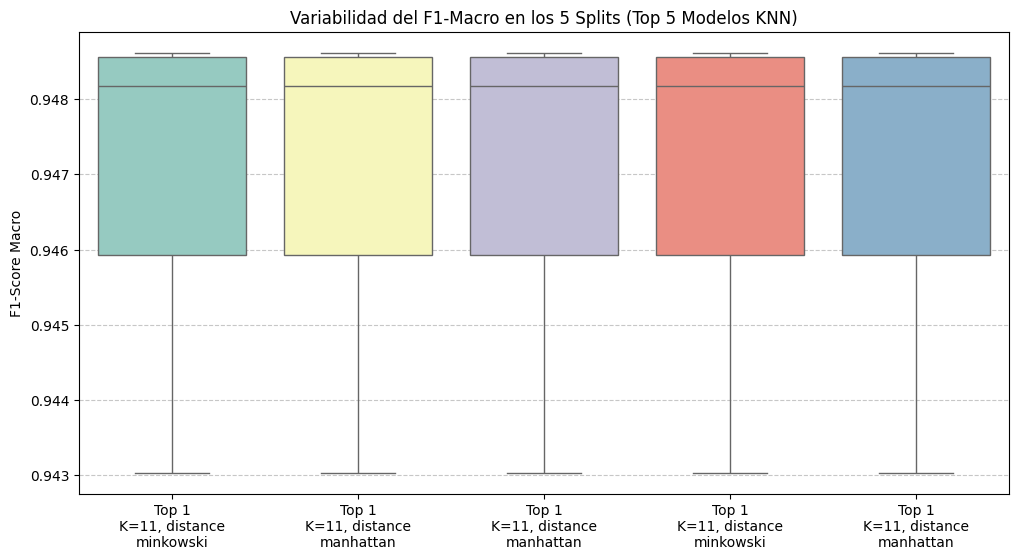

In [8]:
top_5_idx = results_df['rank_test_score'].nsmallest(5).index
top_5_models = results_df.loc[top_5_idx].copy()

split_cols = [f'split{i}_test_score' for i in range(5)]
df_splits = top_5_models[split_cols].transpose()

labels = []
for i, row in top_5_models.iterrows():
    label = (f"Top {int(row['rank_test_score'])}\n"
             f"K={row['n_neighbors']}, {row['weights']}\n"
             f"{row['metric']}")
    labels.append(label)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_splits, palette="Set3")

plt.xticks(range(5), labels)
plt.title('Variabilidad del F1-Macro en los 5 Splits (Top 5 Modelos KNN)')
plt.ylabel('F1-Score Macro')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()